In [1]:
from neurodiffeq import diff
from neurodiffeq.pde import DirichletBVP2D, ExampleGenerator2D, Monitor2D, solve2D
from neurodiffeq.networks import FCNN

import numpy as np
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d  import Axes3D

<IPython.core.display.Javascript object>


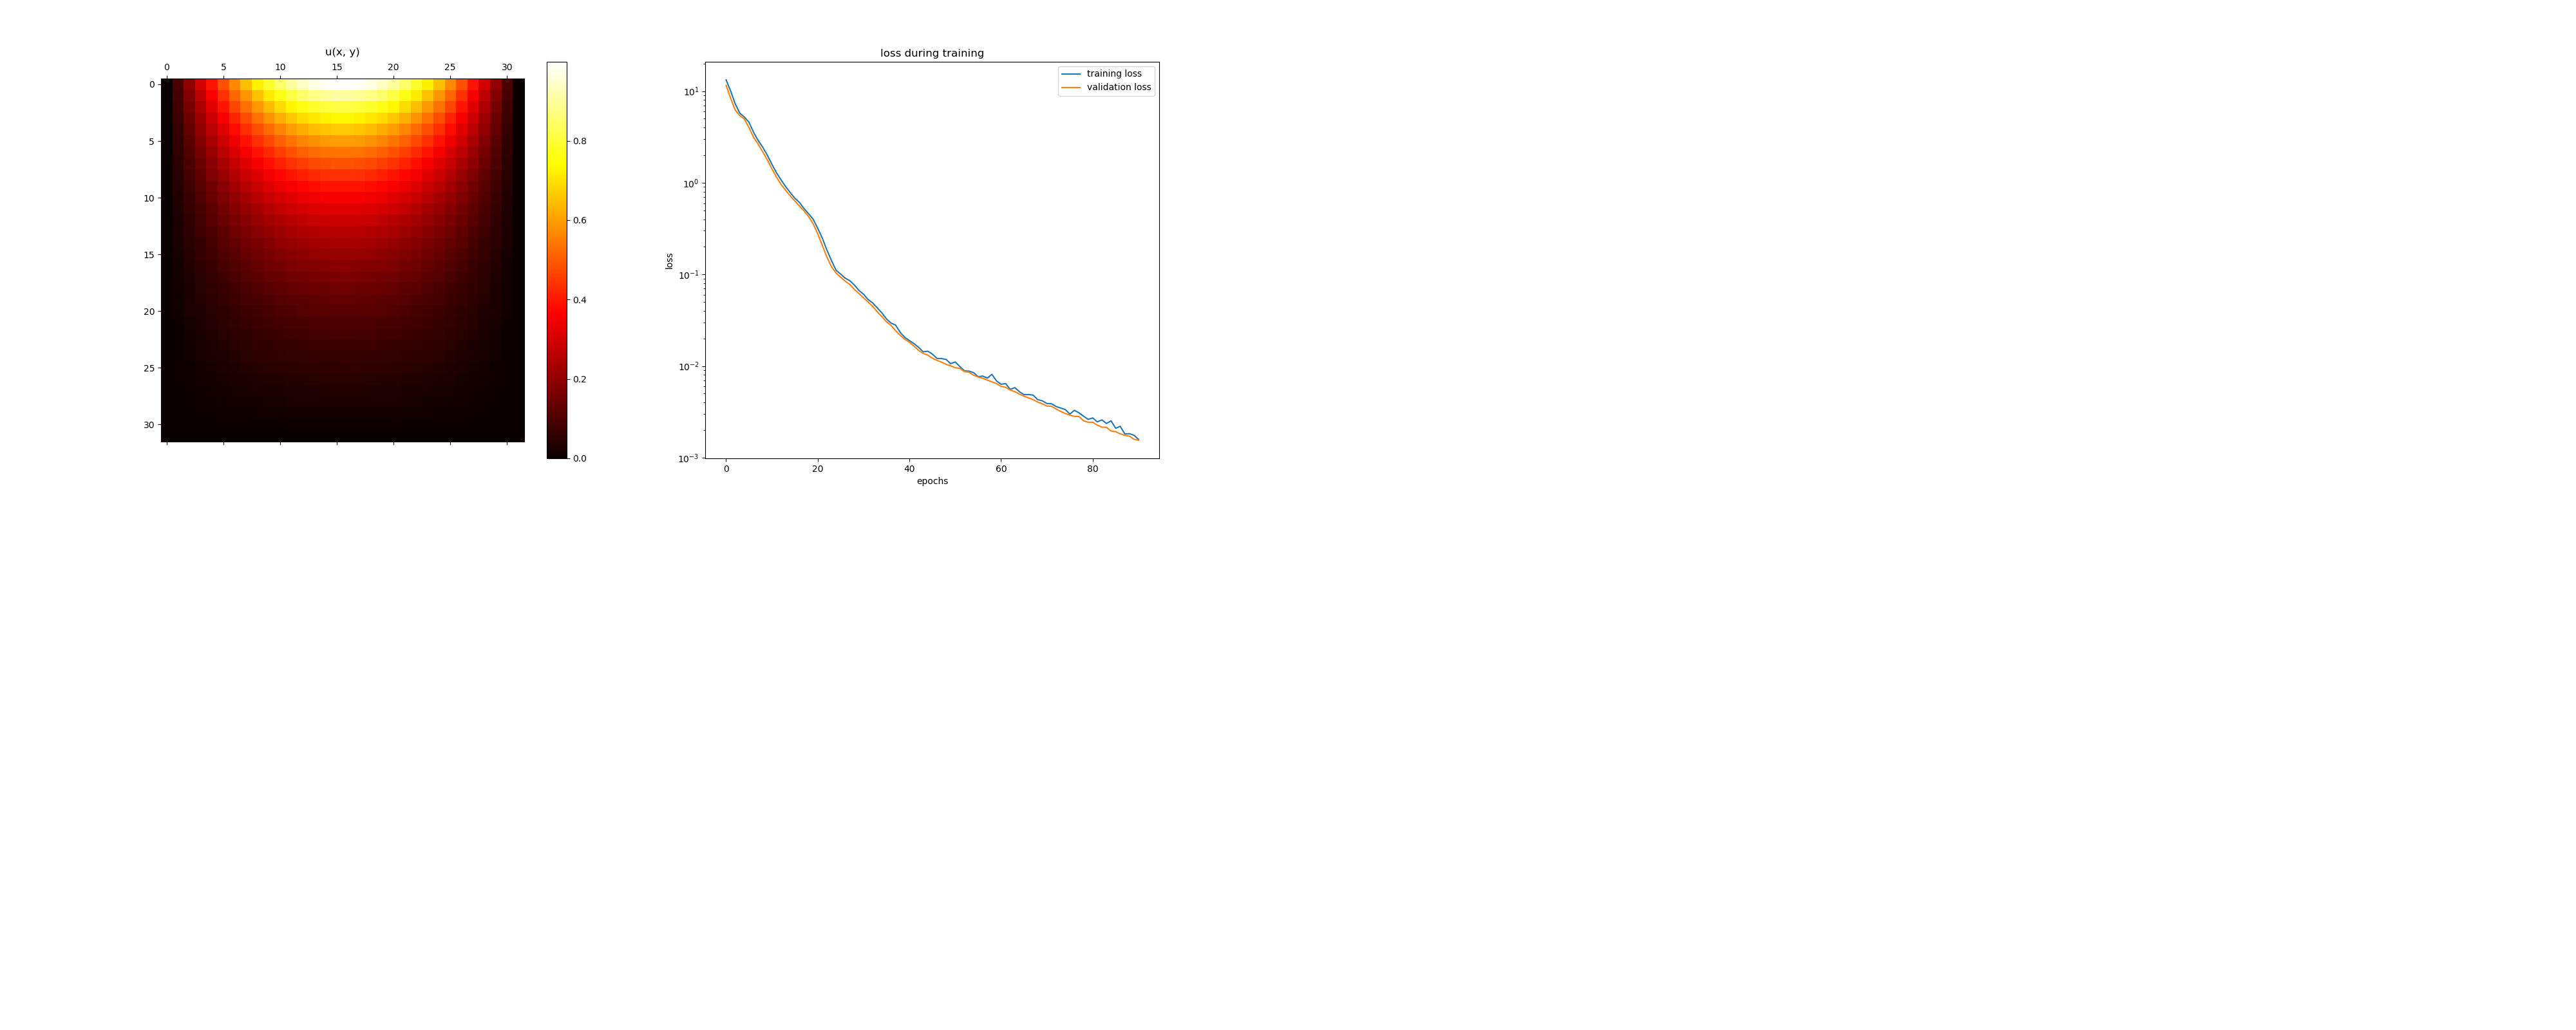

In [2]:
%matplotlib notebook
laplace = lambda u, x, y: diff(u, x, order=2) + diff(u, y, order=2)
BC = DirichletBVP2D(
    x_min=0, x_min_val=lambda y: torch.sin(np.pi*y), 
    x_max=1, x_max_val=lambda y: 0, 
    y_min=0, y_min_val=lambda x: 0, 
    y_max=1, y_max_val=lambda x: 0
)
net = FCNN(n_input_units=2, n_hidden_units=32, n_hidden_layers=2)

solution_neural_net, _ = solve2D(
    pde=laplace, condition=BC, xy_min=[0, 0], xy_max=[1, 1],
    net=net, max_epochs=100, 
    train_generator=ExampleGenerator2D([32, 32], [0, 0], [1, 1], method='equally-spaced-noisy'),
    batch_size=64,
    monitor=Monitor2D(check_every=10, xy_min=[0, 0], xy_max=[1, 1])
)

In [3]:
def plt_surf(xx, yy, zz, z_label='u'):
    %matplotlib inline
    fig  = plt.figure(figsize=(16, 8))
    ax   = Axes3D(fig)
    surf = ax.plot_surface(xx, yy, zz, rstride=2, cstride=1, alpha=0.8, cmap='hot')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel(z_label)
    ax.set_proj_type('ortho')
    plt.show()

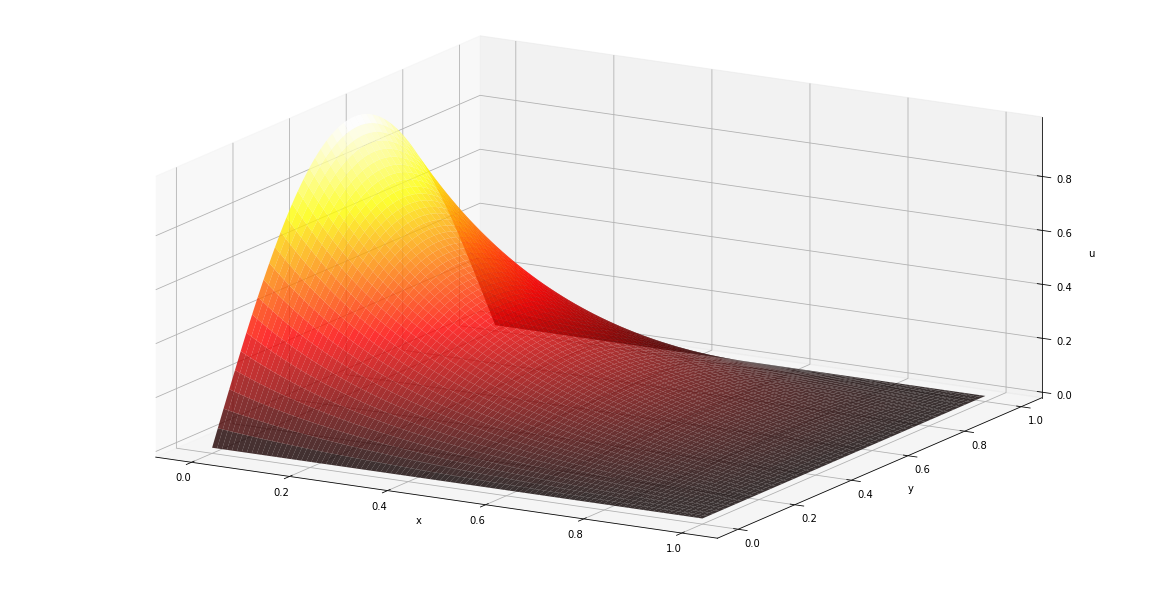

In [4]:
xs, ys = np.linspace(0, 1, 100), np.linspace(0, 1, 100)
xx, yy = np.meshgrid(xs, ys)
sol_net = solution_neural_net(xx, yy, as_type='np')
plt_surf(xx, yy, sol_net)

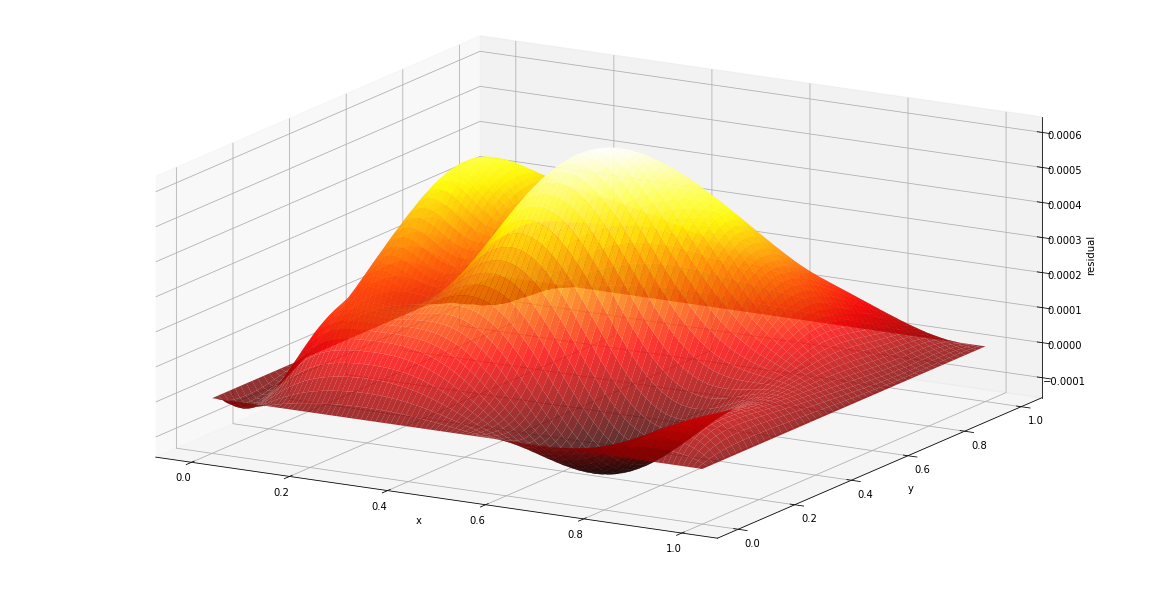

In [5]:
solution_analytical = lambda x, y: np.sin(np.pi*y) * np.sinh(np.pi*(1-x))/np.sinh(np.pi)
sol_ana = solution_analytical(xx, yy)
plt_surf(xx, yy, sol_net-sol_ana, z_label='residual')

In [6]:
class Heat1DIBVP:
    
    def __init__(self, x_min, x_min_val, x_max, x_max_val, t_min, t_min_val, t_max):
        self.x_min, self.x_min_val = x_min, x_min_val
        self.x_max, self.x_max_val = x_max, x_max_val
        self.t_min, self.t_min_val = t_min, t_min_val
        self.t_max = t_max
    
    def enforce(self, u, x, t):
        x_tilde = (x-self.x_min) / (self.x_max-self.x_min)
        t_tilde = (t-self.t_min) / (self.t_max-self.t_min)
        Axt = (1-x_tilde)*self.x_min_val(t) + x_tilde*self.x_max_val(t) + \
              (1-t_tilde)*( self.t_min_val(x) - (1-x_tilde)*self.t_min_val(torch.zeros_like(x_tilde))
                                              -    x_tilde *self.t_min_val(torch.ones_like(x_tilde))
                          ) 
        return Axt + x_tilde*(1-x_tilde)*t_tilde*u

<IPython.core.display.Javascript object>


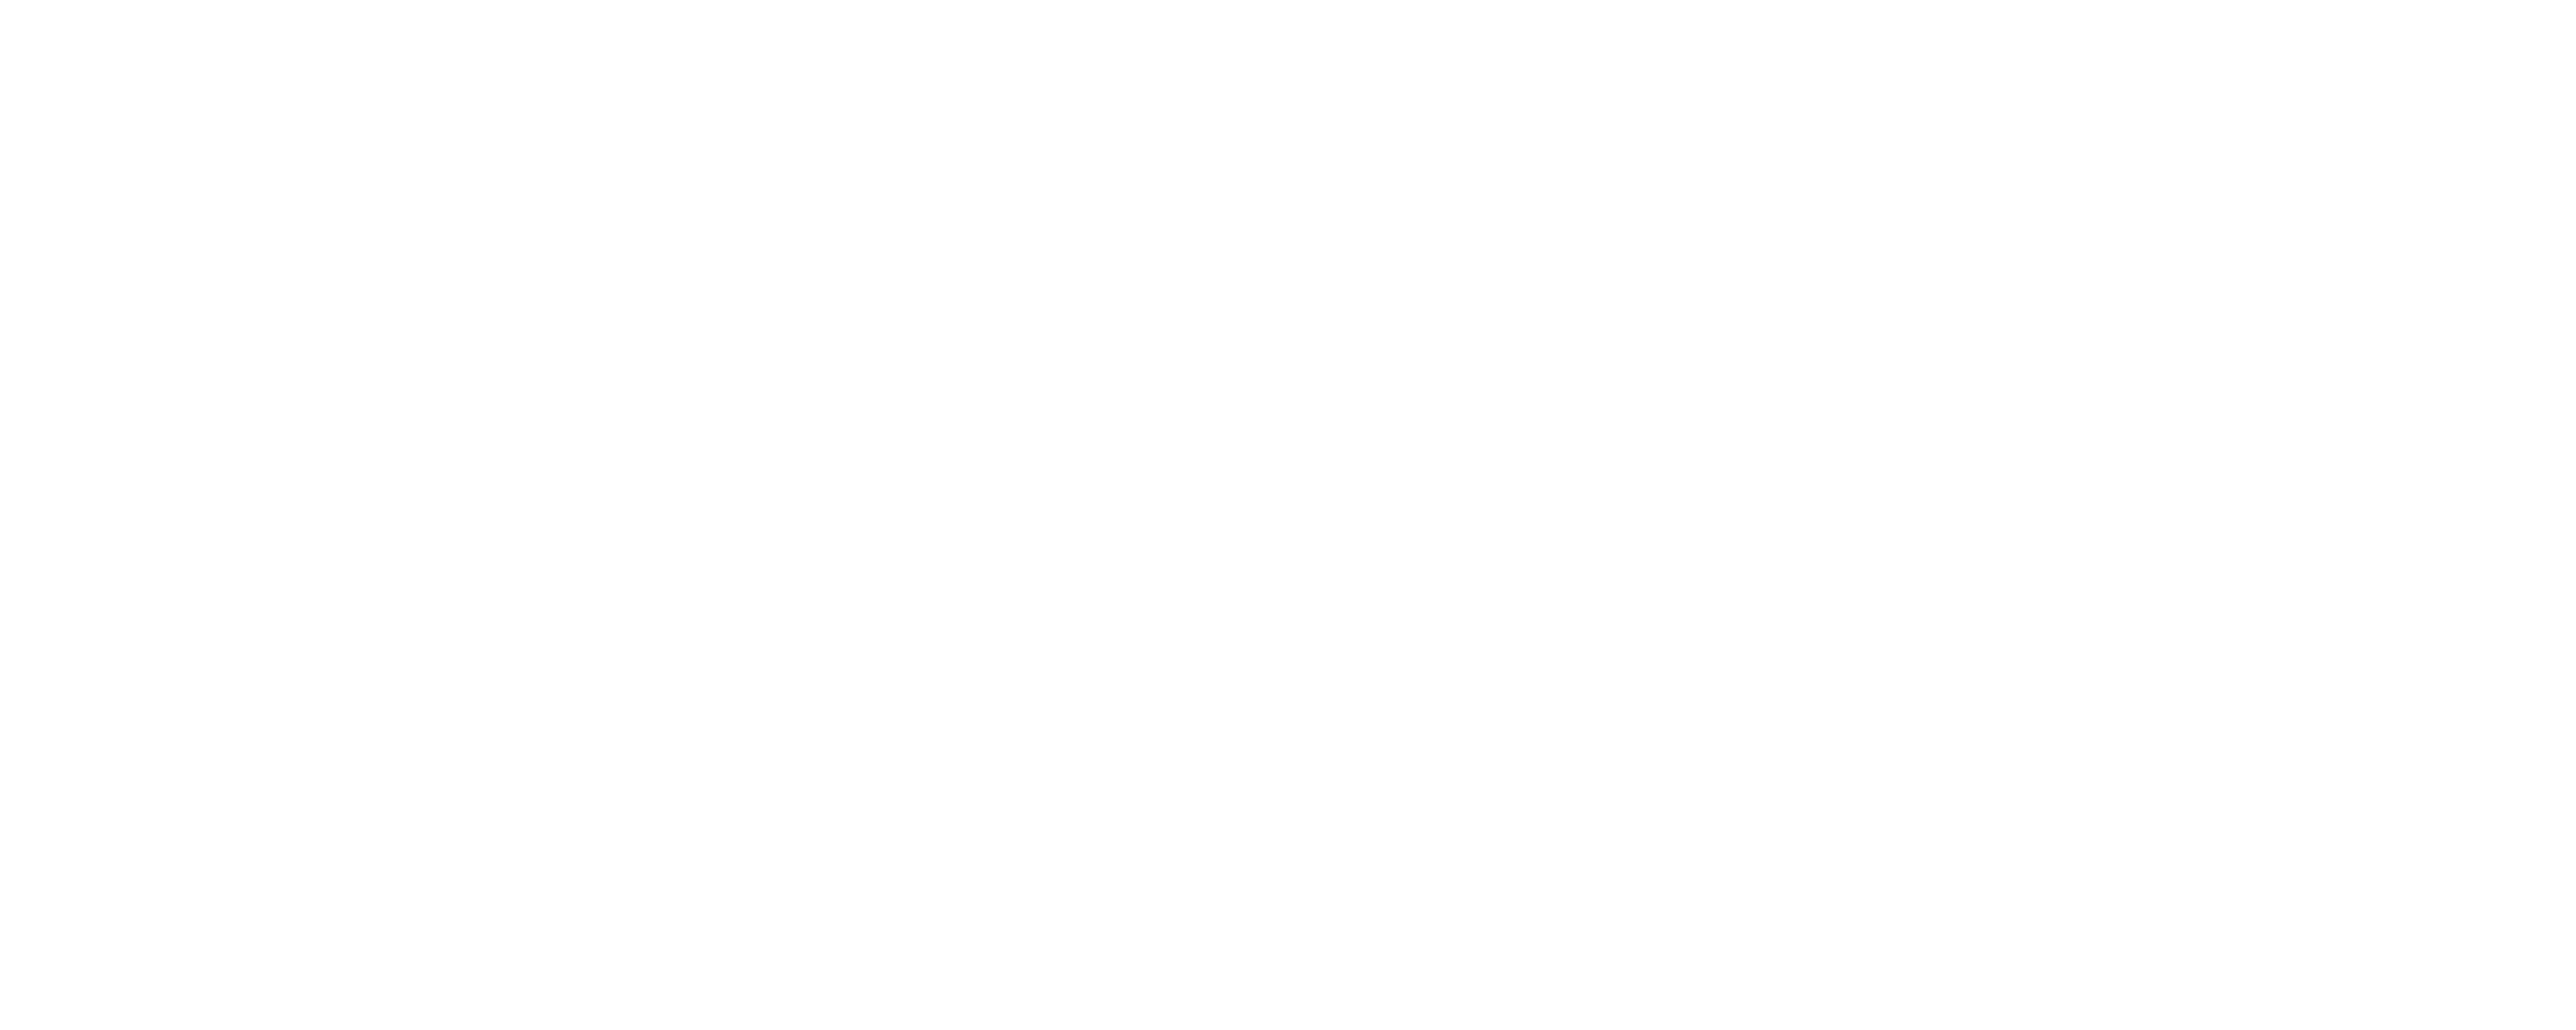

<IPython.core.display.Javascript object>


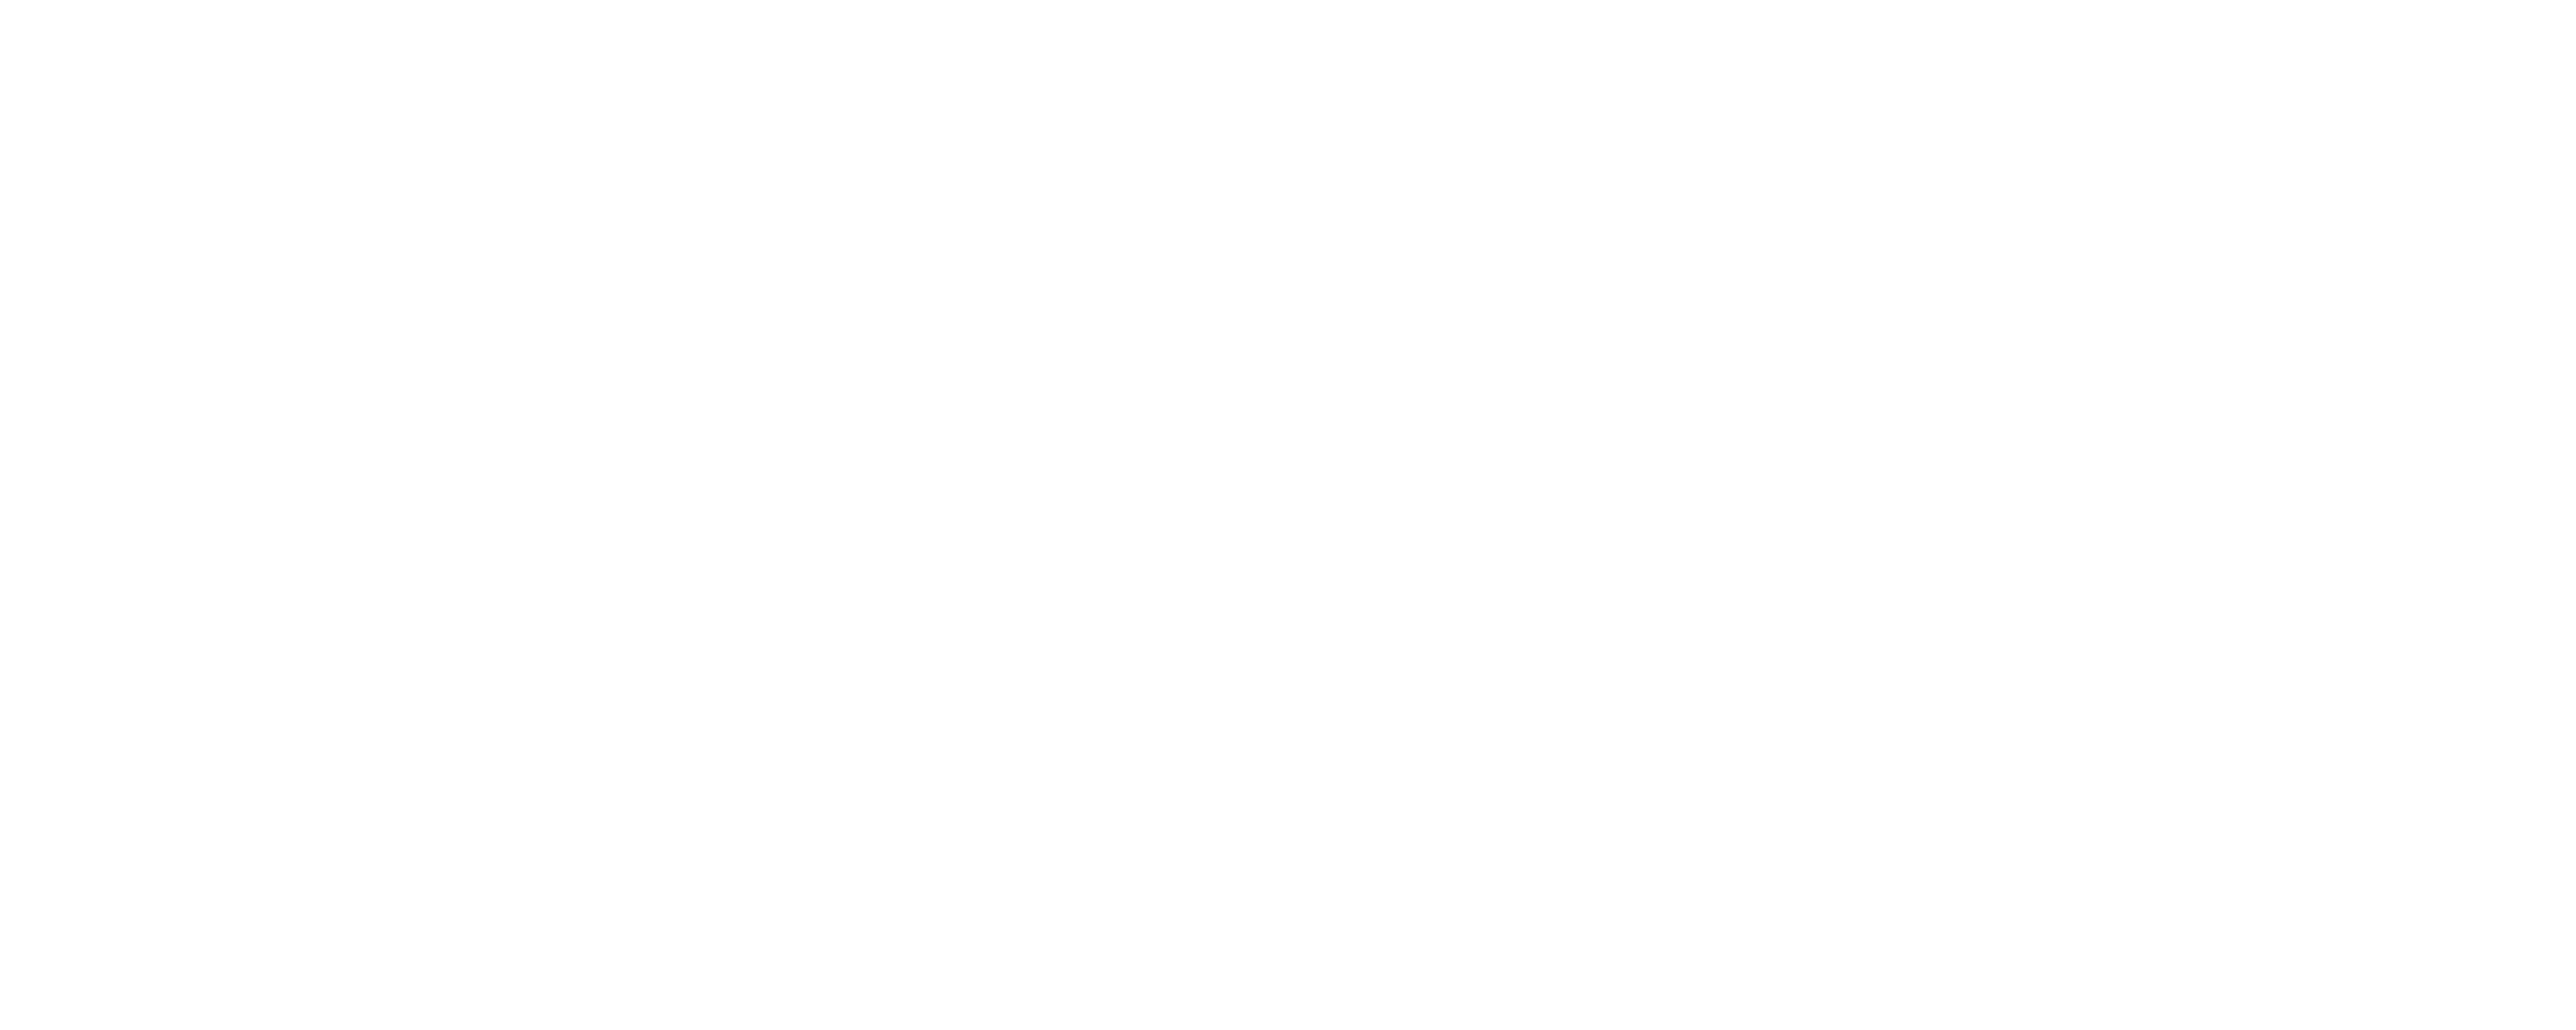

In [7]:
%matplotlib notebook
k = 0.1
heat = lambda u, x, t: diff(u, t) - k * diff(u, x, order=2)
BC = Heat1DIBVP(
    x_min=0, x_min_val=lambda t: 0.5 * t, 
    x_max=1, x_max_val=lambda t: 0,
    t_min=0, t_min_val=lambda x: 0, 
    t_max=2
)
net = FCNN(n_input_units=2, n_hidden_units=32, n_hidden_layers=2)

solution_neural_net, _ = solve2D(
    pde=heat, condition=BC, xy_min=[0, 0], xy_max=[1, 1],
    net=net, max_epochs=100, 
    train_generator=ExampleGenerator2D([32, 32], [0, 0], [1, 1], method='equally-spaced-noisy'),
    batch_size=64,
    monitor=Monitor2D(check_every=10, xy_min=[0, 0], xy_max=[1, 1])
)

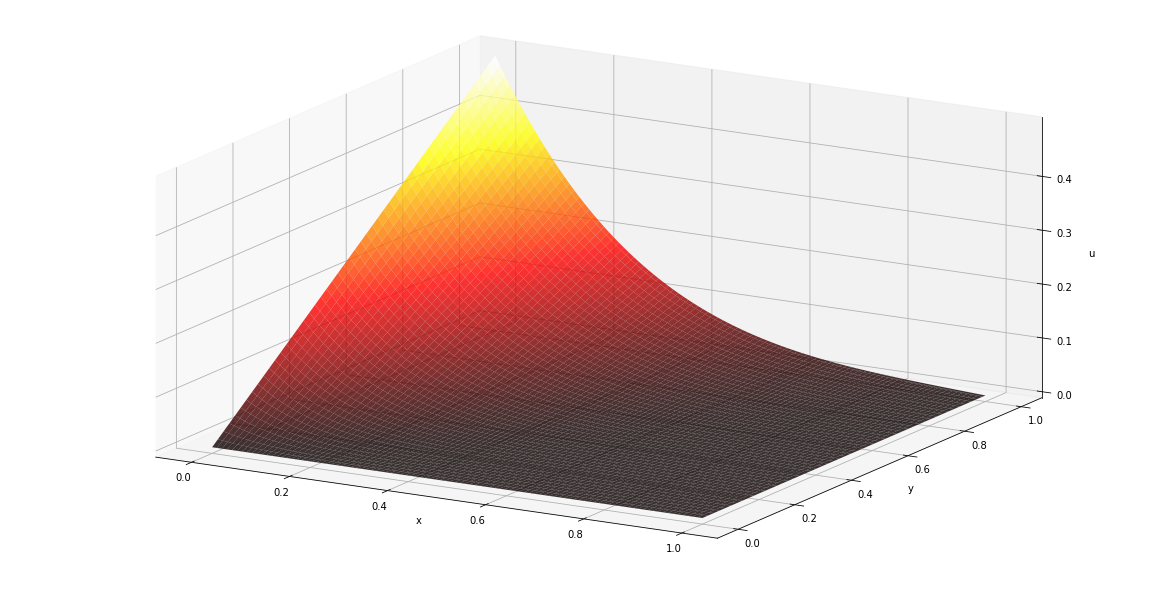

In [8]:
xs, ys = np.linspace(0, 1, 100), np.linspace(0, 1, 100)
xx, yy = np.meshgrid(xs, ys)
sol_net = solution_neural_net(xx, yy, as_type='np')
plt_surf(xx, yy, sol_net)

In [9]:
## set up a numerial solution
## better visualization?